# Tutorial 2: Building a first model

After the EDA of the last session we are now ready to build a first model. In this tutorial, we'll cover

- Data preparation and feature engineering (One-Hot-Encoding)
- Training a first model (Train/Test/Validation split, KNN)
- Model evaluation (RMSLE)
- Submitting model predictions to the leaderboard

As usual, we start by importing all relevant libraries.

In [1]:
# Importing the required libraries and packages
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import sys

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
plt.style.use('fivethirtyeight')

## Working with local imports

In this notebook we will use self-written function. To make this work we need some additional setup.
The pwd command shows you the current working directory. All paths and imports need to be relative to this.

In [2]:
%pwd

'C:\\Users\\bhavrang\\Documents\\Analytics vidhya\\GlobalDataChallenge-II\\global_data_science_challenge_2_public-master\\notebooks'

We want to import function that are located in the *src* directory of the main folder. To do this, we need to let python know that it should look there for imports. This is done by adding the main folder to the project path.

In [3]:
sys.path.append('..')  # '..' is the shortcut for the parent directory of the current working directory

With the extended path we can now use our local imports. These will be introduced later.

In [4]:
from src.data_preparation import compute_work_item_times, split_times
from src.evaluate import rmsle

## Loading the data
We start by loading and preparing the data as introduced in tutorial 1.

In [5]:
file_path='../data/gdsc2_public.csv'
df = pd.read_csv(file_path, sep=';', parse_dates=['timestamp'])
df.from_phase.fillna('Start', inplace=True)  
df.to_phase.fillna('End', inplace=True)
df.head()

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource
0,2015-01-02 14:39:14,WI_000001,WT_00001,WP_00003,BD_00001,PL_00001,NaN,Start,Analyze,NaN,ER_00043
1,2015-01-02 15:04:20,WI_000002,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,Start,Analyze,NaN,ER_00225
2,2015-01-02 15:28:22,WI_000003,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,Start,Analyze,NaN,ER_00225
3,2015-01-02 15:33:54,WI_000004,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,Start,Analyze,NaN,ER_00225
4,2015-01-02 16:32:11,WI_000005,WT_00002,WP_00003,BD_00003,PL_00003,CO_00113,Start,Analyze,NaN,ER_00206


In tutorial 1, we computed start time, end time and duration for each work item. The function *compute_work_item_times* does the same.

In general, it is a good idea to refactor more complex functions into separate Python modules. This makes the notebook easier to read and allows us to use best practices from software development (e.g. unit tests). You can see the source code in the file *src/data_preparation.py*.

In [6]:
times = compute_work_item_times(df)
times.head()

,work_item,start,end,duration,duration_in_days
0,WI_000001,2015-01-02 14:39:14,2015-01-27 11:36:51,24 days 20:57:37,24.87
1,WI_000002,2015-01-02 15:04:20,2015-01-14 09:46:37,11 days 18:42:17,11.78
2,WI_000003,2015-01-02 15:28:22,2015-02-26 11:50:37,54 days 20:22:15,54.85
3,WI_000004,2015-01-02 15:33:54,2015-01-28 09:11:05,25 days 17:37:11,25.73
4,WI_000005,2015-01-02 16:32:11,2015-02-04 12:57:49,32 days 20:25:38,32.85


## Training data, test data and final predictions
In order to do any modelling we have to define on which data our model can train on. It is a best practice to have a separate data set that is used only for evaluation. Finally, we also have to define the work items for which we have to predict the lead times for the competition.

We start by defining the open and closed work items.


In [7]:
is_open = pd.isnull(times.duration)
times_open = times[is_open]  
times_closed = times[~is_open]  # The ~ operator negates a boolean mask
times_closed.head(2)

,work_item,start,end,duration,duration_in_days
0,WI_000001,2015-01-02 14:39:14,2015-01-27 11:36:51,24 days 20:57:37,24.87
1,WI_000002,2015-01-02 15:04:20,2015-01-14 09:46:37,11 days 18:42:17,11.78


- times_open contains all the work items that are still in progress, i.e. the item for which we will have to create a prediction
- times_closed contains all work items that are finished. We can use these for training and evaluating our model

The next step is to split the closed items into two separate sets. We will use one for training and the other for testing.
In our application, we will always have to train our algorithm on the tickets before a certain date, and predict the lead time for all the tickets that were open on that date. To stay as close as possible to our actual business problem, we mimick this situation in our training setup.

We start by defining a separation date $d$. 
- Tickets that were closed before $d$ will be used for training. 
- Tickets that were closed after $d$ will be used for testing.

In [8]:
print(min(times_closed.end))
print(max(times_closed.end))

2015-01-06 09:18:30
2018-03-30 17:15:03


Lets take the first of January 2018 as the separation date. With this we can now define the train and test data.

In [9]:
sep_date_str = '01.01.2018'
sep_date = dt.datetime.strptime(sep_date_str, '%d.%m.%Y')
train_times_tmp = times_closed[times_closed.end <= sep_date]
test_times_tmp = times_closed[(times_closed.end > sep_date) & (times_closed.start <= sep_date)]
test_times_tmp.head()

,work_item,start,end,duration,duration_in_days
196,WI_000197,2015-01-23 15:45:50,2018-02-09 13:54:39,1112 days 22:08:49,1112.92
435,WI_000436,2015-02-18 13:11:50,2018-02-01 16:53:59,1079 days 03:42:09,1079.15
518,WI_000519,2015-03-02 15:32:10,2018-01-09 11:37:11,1043 days 20:05:01,1043.84
910,WI_000911,2015-04-14 17:36:26,2018-02-12 07:21:15,1034 days 13:44:49,1034.57
1121,WI_001122,2015-05-19 10:23:47,2018-03-16 14:47:51,1032 days 04:24:04,1032.18


For simplicity, we added a function that takes a separation date and returns the train, test dataset as well as the open work items. The source code is also part of the *src/data_preparation.py* module.

In [10]:
train_times, test_times, closed_times, open_times = split_times(times, sep_date_str)
print(len(train_times))
print(len(test_times))
print(len(closed_times))
print(len(open_times))
test_times.head()

9290
548
10522
1042


,work_item,start,end,duration,duration_in_days
196,WI_000197,2015-01-23 15:45:50,2018-02-09 13:54:39,1112 days 22:08:49,1112.92
435,WI_000436,2015-02-18 13:11:50,2018-02-01 16:53:59,1079 days 03:42:09,1079.15
518,WI_000519,2015-03-02 15:32:10,2018-01-09 11:37:11,1043 days 20:05:01,1043.84
910,WI_000911,2015-04-14 17:36:26,2018-02-12 07:21:15,1034 days 13:44:49,1034.57
1121,WI_001122,2015-05-19 10:23:47,2018-03-16 14:47:51,1032 days 04:24:04,1032.18


**Exercise:** One essential requirement for doing any machine learning is that the data we train on is similar to the data we test on. Do an EDA on both the train and test data and compare the results. What do you find?

## A baseline model
Before we start with any serious modelling, we recommend to define a baseline to get an idea about the difficulty of the task and to have a lower limit for the prediction performance. The baseline should be
- Easy to understand
- Easy to implement

All *proper* models should perform better than the baseline. 
We will take the median work item duration as the baseline model. 

First, we compute the median duration on the training data

In [11]:
median_duration = train_times.duration_in_days.median()

Now, we create a prediction that is exactly the median for each work item for both the training and test data

In [12]:
train_predictions = pd.DataFrame(train_times.work_item)  # Initialize the DataFrame
train_predictions['predictions'] = median_duration  # Add the predictions
test_predictions = pd.DataFrame(test_times.work_item)
test_predictions['predictions'] = median_duration

For comparison, we show both the actual duration and predicted duration for a few work items.

In [13]:
pd.merge(train_times, train_predictions).head()

,work_item,start,end,duration,duration_in_days,predictions
0,WI_000001,2015-01-02 14:39:14,2015-01-27 11:36:51,24 days 20:57:37,24.87,17.735
1,WI_000002,2015-01-02 15:04:20,2015-01-14 09:46:37,11 days 18:42:17,11.78,17.735
2,WI_000003,2015-01-02 15:28:22,2015-02-26 11:50:37,54 days 20:22:15,54.85,17.735
3,WI_000004,2015-01-02 15:33:54,2015-01-28 09:11:05,25 days 17:37:11,25.73,17.735
4,WI_000005,2015-01-02 16:32:11,2015-02-04 12:57:49,32 days 20:25:38,32.85,17.735


To measure the overall performance of our prediction, we use the *RMSLE*, the *Root Mean Square Log Error* which is defined as:

$$\sqrt{\frac{1}{n}\sum_{i=1}^{n}(\log(p_{i}+1)-\log(a_{i}+1))^2}$$

where 
- $n$ is the number of work items
- $p_{i}$ is the predicted duration for the $i$th work item
- $a_{i}$ is the actual duration for the $i$th work item

The lower the error, the better. A perfect prediction gives an error of 0. The *RMSLE* is implemented in *src/evaluate.py*.

In [14]:
rmsle(train_times, train_predictions)

1.616016923543129

In [15]:
rmsle(test_times, test_predictions)

2.0978309963429287

The score on the training data shows us the upper limit of our model. We cannot expect to get better results than this.
The score on the test data indicates the performance we can expect on new data. This is the value that we need to optimize.

We are also interested in the comparison between training and test score. We aim for similar values. 
- If the training score is much lower that the test score, we are *overfitting* the model to the data. You should change the features or the model to combat this. 
- If the test score is much lower than the training score the most likely explanantion is that either there are differences in the distributions of the training and testing data, or you made a mistake during the data preparation.

**Exercise: How does the score change when we use the mean instead of median as prediction?**

We can also upload our predictions to the scoreboard to see how we fare compared to the other participants. To do this, we need to create predictions for all the work items that are currently open. 

In [16]:
open_predictions = pd.DataFrame(open_times.work_item)
open_predictions['predictions'] = closed_times.duration_in_days.median()  # Use all available data for the final prediction

We save the *open_predictions* as a csv file and upload it to *http://10.41.72.110:8000/submit/*. Note that you need to be logged in for the link to work.

In [17]:
with open('open_predictions_median.csv', 'w') as f:
    open_predictions.to_csv(f, index=False)

You will find the file *open_predictions_median.csv* in your current working directory (type %pwd to see what it is), usually the same directory where the notebook is stored.

## The first machine learning model
Now it is time to train our first machine learning model. We will use the KNNRegressor algorithm (k-Nearest-Neighbour). It is easy to understand and allows us to introduce the main concepts. To predict the lead time $l(w)$ for a work item $w$, the default [KNNRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) algorithm:

1. Finds the $k$ work items $w_i, ..., w_k$ in your training data that are most similar to $w$, aka the *Nearest Neighbours*
2. Sets the lead time prediction for $w$ as the mean lead time of the $k$ most similar work items $w_1, .., w_k$: 
$$l(w) = \frac{1}{k}\sum_{i=1}^k l(w_i)$$

But how can we define similarity between work items? 

In [18]:
df.head()

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource
0,2015-01-02 14:39:14,WI_000001,WT_00001,WP_00003,BD_00001,PL_00001,NaN,Start,Analyze,NaN,ER_00043
1,2015-01-02 15:04:20,WI_000002,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,Start,Analyze,NaN,ER_00225
2,2015-01-02 15:28:22,WI_000003,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,Start,Analyze,NaN,ER_00225
3,2015-01-02 15:33:54,WI_000004,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,Start,Analyze,NaN,ER_00225
4,2015-01-02 16:32:11,WI_000005,WT_00002,WP_00003,BD_00003,PL_00003,CO_00113,Start,Analyze,NaN,ER_00206


As usual, there is more than one solution. We will start by only looking at *work_type* and *work_priority*: We define that two work items are equal, if and only if they have the same work type and same work priority. To do this, we will use a One-Hot-Encoding of the categorical features *work_type* and *work_priority*.

In [19]:
# The train/test times df tells us which work items we can use for training/testing
train_work_items = set(train_times.work_item)  
test_work_items = set(test_times.work_item)  
# Both the work type and work priority might change over time. 
# For now, we'll take the values the work item had when it was created.
df_start_only = df[df.from_phase == 'Start']
# To extract the work type and work priority, we need to filter on the original data
train_df = df_start_only[df_start_only.work_item.isin(train_work_items)]  
test_df = df_start_only[df_start_only.work_item.isin(test_work_items)]

We fit the OneHotEncoder on the training data and then transform both the training and the test data. 

(Note that the easy distiction between fitting and transforming is reason we use OneHotEncoder instead of pd.get_dummies. It makes deployment easier.)

In [20]:
onehotencoder = OneHotEncoder(sparse=False)
cols_to_encode = ['work_type', 'work_priority']
train_features = onehotencoder.fit_transform(train_df[cols_to_encode])
test_features = onehotencoder.transform(test_df[cols_to_encode])

To get a better understanding of the transformation, let's take a look at two different work items and their features

In [21]:
print(train_df.loc[0])  # We use .loc[0] to access the first row of a DataFrame
print(train_features[0])  # We use [0] to access the first entry in an array

timestamp        2015-01-02 14:39:14
work_item                  WI_000001
work_type                   WT_00001
work_priority               WP_00003
domain                      BD_00001
platform                    PL_00001
components                       NaN
from_phase                     Start
to_phase                     Analyze
from_resource                    NaN
to_resource                 ER_00043
Name: 0, dtype: object
[1. 0. 0. 0. 0. 1. 0. 0.]


In [22]:
print(train_df.loc[1])
print(train_features[1])

timestamp        2015-01-02 15:04:20
work_item                  WI_000002
work_type                   WT_00002
work_priority               WP_00004
domain                      BD_00002
platform                    PL_00002
components         CO_00037/CO_00071
from_phase                     Start
to_phase                     Analyze
from_resource                    NaN
to_resource                 ER_00225
Name: 1, dtype: object
[0. 1. 0. 0. 0. 0. 1. 0.]


The first three columns encode the work type
- The first column in train_features is 1 iff the work type is WT_0001.
- The second column in train_features is 1 iff the work type is WT_0002.
- The third column in train_features is 1 iff the work type is WT_0003.

Similarly, the remaining columns encode the the work priority. You can see the mapping by calling the *get_feature_names* function:

In [23]:
onehotencoder.get_feature_names()

array(['x0_WT_00001', 'x0_WT_00002', 'x0_WT_00003', 'x1_WP_00001',
       'x1_WP_00002', 'x1_WP_00003', 'x1_WP_00004', 'x1_WP_00005'],
      dtype=object)

In [29]:
train_df[cols_to_encode]

,work_type,work_priority
0,WT_00001,WP_00003
1,WT_00002,WP_00004
2,WT_00002,WP_00004
3,WT_00002,WP_00004
4,WT_00002,WP_00003
5,WT_00002,WP_00003
6,WT_00002,WP_00003
8,WT_00002,WP_00003
9,WT_00002,WP_00003
11,WT_00002,WP_00003


Now that we have a mapping from data points to a vector space, we can use any metric between the two feature vectors to define similarity. 

The process of mapping the information about a data point into a vector space is called **feature engineering**.
The quality of your results will hugely depend on the features you engineer. Changing the mapping is an easy way of improving your results as we will see later.

The next step is to define and fit the actual model with all hyperparameters.

In [24]:
knn = KNeighborsRegressor()
knn.fit(train_features, train_times.duration_in_days)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [32]:
len(train_df)

9290

Note the *metric='minkowski'* parameter that defines the similarity between two work items. Check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) to learn about other options.

As before, we create predictions for the train and test data and compute the *rmsle*

In [25]:
train_predictions = pd.DataFrame(train_times.work_item)  
train_predictions['predictions'] = knn.predict(train_features)
test_predictions = pd.DataFrame(test_times.work_item)
test_predictions['predictions'] = knn.predict(test_features)
print(rmsle(train_times, train_predictions))
print(rmsle(test_times, test_predictions))

1.9927739627081689
1.4920379330188251


The *RMSLE* on the training data is actually higher than our baseline. This should not happen. However, the *RMSLE* on our test data is a lot lower than the the baseline value.

A scatterplots of the predictions vs the actual durations can help us get additional insights.

Text(0.5, 0, 'Actual duration')

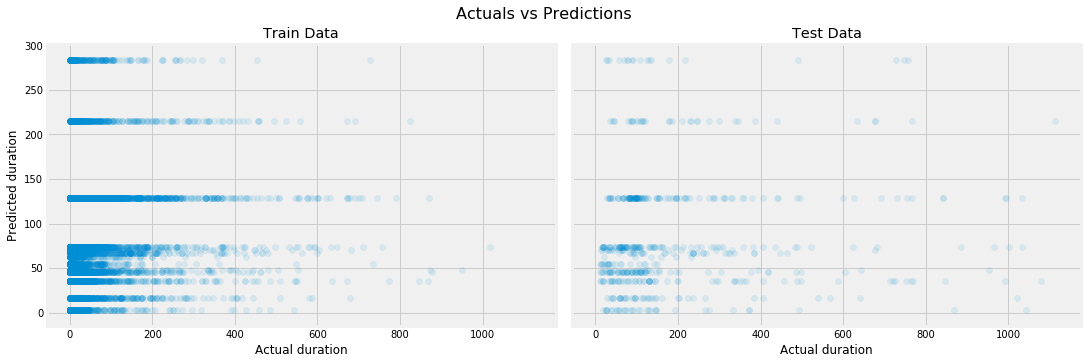

In [26]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(15,5), sharey=True, sharex=True)
fig.suptitle('Actuals vs Predictions', fontsize=16)
axs[0].scatter(x=train_times.duration_in_days, y=train_predictions.predictions, alpha=0.1)
axs[0].set_title('Train Data')
axs[0].set_xlabel('Actual duration')
axs[0].set_ylabel('Predicted duration')
axs[1].scatter(x=test_times.duration_in_days, y=test_predictions.predictions, alpha=0.1)
axs[1].set_title('Test Data')
axs[1].set_xlabel('Actual duration')

If our predictions were perfect, we would see a diagonal line. Unfortunately, this is not the case. There are two main observations

1. There is a big difference between the highest predicted duration (200 days) and the actual maximum (over 1200 days)
2. Our model is not expressive enough: It only predicts a handful of different numbers. 

**Exercises:**

- Investigate why there is this big difference between the training and test performance. How should you deal with this?
- How does changing the separation date effect the performance?
- Create a new open_prediction.csv file for the KNNRegressor prediction and upload it to the leaderboard. How does is compare to the baseline.
- Experiment with different feature encodings. E.g. by changing the columns to encode
```python
cols_to_encode = ['work_type', 'work_priority', 'domain']
```
- Try out different hyperparameters for the model e.g. via
```python
knn = KNeighborsRegressor(n_neighbors=10, metric='minkowski', p=1)
```
- Try out different model types, e.g. a linear or SVM model, and compare the results. Check the [scikit-learn](https://scikit-learn.org/stable/supervised_learning.html) library for ideas.

## Submitting the results to the public leaderboard
In order to compete, we will need to create predictions for all open work items. For this, we need to
- Train a model on all closed work items
- Create predictions on all open work items
- Submit the predictions to the website

In [27]:
# All work items that are finished become our training data, all open work items our test data
closed_work_items = set(closed_times.work_item)  
open_work_items = set(open_times.work_item)  
closed_df = df_start_only[df_start_only.work_item.isin(closed_work_items)]  
open_df = df_start_only[df_start_only.work_item.isin(open_work_items)]

# Compute the features
onehotencoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
cols_to_encode = ['work_type', 'work_priority']
closed_features = onehotencoder.fit_transform(closed_df[cols_to_encode])
open_features = onehotencoder.transform(open_df[cols_to_encode])

model = KNeighborsRegressor()
model.fit(closed_features, closed_times.duration_in_days)
open_predictions = pd.DataFrame(open_times.work_item)
open_predictions['predictions'] = model.predict(open_features)

with open('open_predictions_knn_wt_wp.csv', 'w') as f:
    open_predictions.to_csv(f, index=False)

With an RMSLE of around 1.81, the results are between our training and test result. Usually, you'd want the validation results to be similar to the test results. One difference between our test set and the one on the website it that we only used two month of data, while the official data uses a longer timespan (around 6 month).  It seems that we will need to define a better test set. 

## Conclusion
This concludes the second tutorial. We covered basic features engineering via One-Hot-Encodings, trained two different models and explored several evaluation methods. 

In the next tutorial, you will learn
- model improvement via hyperparameter tuning and feature engineering
- a better method to measure model quality
- best practices for experiment tracking